In [20]:
using Gen
using Distributions
using PyPlot
using Random
using Flux
using LinearAlgebra
include("helper_functions.jl");

In [21]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
network = "classifier"
#network = "interpolator"

#Data hyperparameters
n = 20 #Number of samples per mode (classifier)
m = 4 #Number of modes (classifier)
d = 2 #Input dimension
N = n*m #Total samples
σₐ = 0.02 #Mode variance (classifier)

#Network hyperparameters
α = 6 #Gamma Scale for Hyperparameters

#Node hyperparameters
k_range = 12 #Maximum number of neurons per layer
k_list = [2]
k_real = 2;

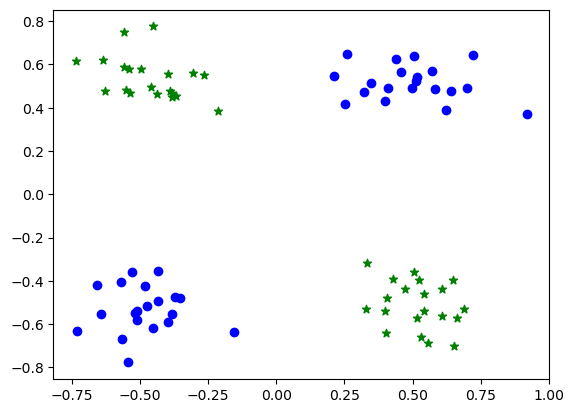

In [22]:
#Data
x_raw, classes = real_data_classifier(Int(N/4), 4, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]
y_real = classes

plot_data_classifier(x_raw,classes)
x = transpose(x_raw)
size(x);

In [23]:
#Bayesian Neural Net
function G(x, trace)
    activation = relu
    layers = 1
    ks = [trace[(:k,i)] for i=1:layers]
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], 1, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

@gen function classifier(x::Array{Float64})
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l = 1
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    k[1] = @trace(categorical([0.0,1.0]), (:k,1))
    obs[(:k,1)] = k[1]
    #for i=1:l
        #k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        #obs[(:k,i)] = k[i]
    #end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    α = 0.001 #Gamma Scale for Hyperparameters
    
    ω₁ = 100
    ω₂ = (sum([obs[(:k,i)] for i=1:l]))*100 #Neal (1996): Scaling relationship to # of hidden units
    τ₁ ~ gamma(ω₁,α) #Hidden Weights
    τ₂ ~ gamma(ω₁,α) #Hidden Biases
    τ₃ ~ gamma(ω₂,α) #Output Weights
    
    #Standard Deviations
    σ₁ = 1/τ₁
    σ₂ = 1/τ₂
    σ₃ = 1/τ₃
    #σᵧ = sqrt(1/τᵧ)
    
    #Sample weight and parameter vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]
    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            μ = zeros(h)
            Σ = Diagonal([σ₁ for i=1:length(μ)])
            W[i] = @trace(mvnormal(μ,Σ), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            μ2 = ones(k[i])
            Σ2 = Diagonal([σ₂ for i=1:length(μ2)])
            b[i] = @trace(mvnormal(μ2,Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            μₒ = zeros(k[l])
            Σₒ = Diagonal([σ₃ for i=1:length(μₒ)])
            W[i] = @trace(mvnormal(μₒ,Σₒ), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            μ2ₒ = ones(1)
            Σ2ₒ = Diagonal([1.0 for i=1:length(μ2ₒ)])
            b[i] = @trace(mvnormal(μ2ₒ,Σ2ₒ), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    y = zeros(length(scores))
    for j=1:N
        y[j] = @trace(categorical([1-scores[j],scores[j]]), (:y,j))
    end

    return scores
    
end;

#(best_trace,) = generate(classifier, (x,), obs)
#println(best_trace[:τ₁])
#println(best_trace[:τ₂])
#println(best_trace[:τ₃])

test_scores = classifier(x)
test_labels = data_labeller(test_scores)
test_acc = sum([classes[i] == test_labels[i] for i=1:length(classes)])

40

In [34]:
traces = []
function select_hyperparameters(trace, obs)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    (new_trace,weight,retdiff) = regenerate(trace, args, argdiffs, select(:τ₁,:τ₂,:τ₃))
    obs[:τ₁] = new_trace[:τ₁]
    obs[:τ₂] = new_trace[:τ₂]
    obs[:τ₃] = new_trace[:τ₃]
    return new_trace, obs
end

function select_selection_NUTS(trace)
    l = 1
    selection = select()
    for i=1:l+1
        push!(selection, (:W,i))
        push!(selection, (:b,i))
    end
    return selection
end

function run_NUTS(trace, iters, obs)
    for i=1:iters
        

        #(new_trace, hmc_score) = NUTS(trace, selection, check=false, observations=obs)
        #if rand(Uniform(0,1)) < exp(hmc_score)
            #trace = new_trace
            #accepted = true
        #else
            #accepted = false
        #end
        #push!(traces, trace)
        #accepted && println("Within accepted")
    end
    return trace
end

obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs = obs_master;
(trace,) = generate(classifier, (x,), obs)

run_NUTS(trace, 1, obs);

[3.2137204125622505, 2.5955636869939083, 1.5041815224545885, 3.8145232520607144, -4.7653195769025, -3.55421523276477, 7.328226979516891, 1.2466869731485186, 0.28337182416457873]
9


In [147]:
function sample_momenta(n::Int)
    Float64[random(normal, 0, 1) for _=1:n]
end

function NUTS(trace, ϵ, check=false, observations = obs, M=1::Int)
    #Get θ₀
    Θ = []
    args = get_args(trace)
    println(get_score(trace))
    retval_grad = accepts_output_grad(get_gen_fn(trace)) ? zero(get_retval(trace)) : nothing
    argdiffs = map((_) -> NoChange(), args)
    selection = select_selection_NUTS(trace)
    (_, values_trie, gradient_trie) = choice_gradients(trace, selection, retval_grad)
    θ₀ = to_array(values_trie, Float64)
    push!(Θ, θ₀)
        
    #Loop M times
    for m=1:M
        #Resample Position Variables
        r₀ = sample_momenta(length(Θ[m]))
        r = r₀.^2
        θ = Θ[m] - 0.5(r)
        θ = from_array(values_trie, θ)
        (new_trace, _, _) = update(trace, args, argdiffs, θ)
        score = exp(get_score(new_trace))
        u = rand(Uniform(0,score))
        
        #Initialize
        θl = Θ[m]
        θr = Θ[m]
        rl = r₀
        rr = r₀
        j=0
        C=Set(tuple(Θ[m], r₀))
        s=1
        
        while s == 1
            vj = rand([-1,1])
            if vj == -1
                θl,θr,rl,rr,Cₐ,sₐ = build_tree(θl,rl,u,vj,j,ϵ)
            else
                θl,θr,rl,rr,Cₐ,sₐ = build_tree(θr,rr,u,vj,j,ϵ)
            end
            if sₐ == 1
                C = union(C,Cₐ)
            end
            #s = sₐ
            j += 1
        end
        #θₐ = (sample from C) 
    end
end

obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs = obs_master;
(trace,) = generate(classifier, (x,), obs)
NUTS(trace, 0.1, false, obs, 1)

-284.982866832033


In [168]:
C = Set(tuple(["Test", 1]))
D = Set(tuple(["Test2", 2]))
union(C,D)

Set{Array{Any,1}} with 2 elements:
  Any["Test", 1]
  Any["Test2", 2]

In [ ]:
function build_tree

In [ ]:
function leapfrog